# Comparison between different kernel functions in polarization densities

One unique feature of **MaxwellLink** is the support of different kernel functions in defining the polarization densities.

In **MaxwellLink** , light-matter interactions are evaluated by
\begin{equation}
V_m = -\int_{\Omega_m} d\mathbf{r} \mathbf{E}(\mathbf{r})\cdot \mathbf{P}^{m}_{\rm{mol}}(\mathbf{r},t),
\end{equation}
where $\Omega_m$ denotes the integration volume, and $\mathbf{P}^{m}_{\rm{mol}}(\mathbf{r},t)$ represents the classical polarization density of molecule $m$, which is defined by
\begin{equation}
\mathbf{P}^{m}_{\rm{mol}}(\mathbf{r},t) = \sum_{i=x,y,z} \gamma \mu_m^i(t) \mathbf{\kappa}_m^{i}(\mathbf{r}) .
\end{equation}
Here, $\mu_m^i(t)$ is the classical molecular dipole moment along direction $i=x,y,z$; $\gamma$ denotes the rescaling factor of the polarization density (with default value 1.0); $\mathbf{\kappa}_m^{i}(\mathbf{r})$ represents the spatial kernel function of molecule $m$ along direction $i=x,y,z$.

At this moment, six different spatial kernel functions are supported in **MaxwellLink**, and they can be defined in the **abstract molecule** class ``Molecule(polarization_type=...)``.

- ``analytical`` Analytical Gaussian distribution (default setting);

- ``numerical`` Numerical Gaussian distribution, which suppies FDTD engines a dataset containing numerical values at different grid points for emitting the E-field;

-  ``transverse`` With this setting, the longitudinal component of the **self-emitted** E-field ($\mathbf{E}_{\parallel}^m$) is not taking into account during light-matter coupling evaluation (to reduce the real-component of the self-generated dyadic Green's function, $G(\mathbf{r}_m, \mathbf{r}_m))$, but the longitudional component of the E-field from other emitters is still taken into account (to account for short-range electrostatic interactions).

-  ``point`` A point dipole distribution (delta function). Here, a point source is used for emitting the field, but during the light-matter evaluations, the E-field averaged over a $\Delta x^3$ box is used (otherwise the results will be totally wrong), where $\Delta x$ denotes the spatial grid point spacing in FDTD;

-  ``point-raw``A point dipole distribution (delta function). Here, a point source is used for emitting the field, and during the light-matter evaluations, the raw E-field at the molecular center is used (which could yield very wrong results in some limits);

-   ``anisotropic`` Anisotropic analytical Gaussian distribution, with different Gaussian widths along different dimensions.

Before jumping in the simulations, let's provide the conclusion first:

## 1. Conclusion

- The reason why **relative large oscillations** in spontaneous emission are observed in all simulations is that we have assigned **a very large dipole moment** for the TLS ($\mu_{12}=187$ a.u.). With smaller dipole moments, the oscillations will be greatly suppressed (and the spontaneous emission will take longer to finish). This simulation can be treated as an extreme pressure test for different polarization densities.

- Overall, although using the ``point`` or ``point-raw`` kernel function reduces the simulation time, it is not recommended in general (except that one has validated the point-dipole approximation in a specific simulation). 

- With very large dipole moments assigned, using the ``transverse`` kernel function can greatly reduce the oscillations (which corresponds to the frequency renormalization in the frequency domain).

To explore how each spatial kernel function yields different dynamics, let's run spontaneous emission for a single two-level system (TLS) coupled to 3D FDTD.  

## 1. Define the spontaneous emission function

First, let's put the spontaneous emission simulation into a single function.

In [1]:
import meep as mp
import maxwelllink as mxl
import maxwelllink.sockets as mxs
import numpy as np
import time
import shlex
import subprocess

def spontaneous_emission(
    sigma=0.1,
    polarization_style="analytical",
):
    """
    End-to-end (socket) TLS relaxation run.
    """
    # --- choose a free port & set up the hub first (server must be up before the client connects) ---
    host, port = mxs.get_available_host_port(localhost=True)

    # SocketHub acts as the server the driver will connect to
    hub = mxl.SocketHub(host=host, port=port, timeout=10.0, latency=1e-5)

    # --- launch the external driver (client) only on rank 0 to avoid multiple clients under MPI ---
    proc = None
    try:
        # --- common simulation setup ---
        cell = mp.Vector3(3, 3, 3)
        geometry = []
        sources_non_molecule = []
        pml_layers = [mp.PML(1.0)]
        resolution = 10

        # TLS physical parameters (used for the analytical rate)
        dipole_moment = 1e-1
        frequency = 2.0

        # one socket-backed molecule; time units 0.1 fs per Meep time
        molecule = mxl.Molecule(
            hub=hub,
            center=mp.Vector3(0, 0, 0),
            size=mp.Vector3(1, 1, 1),
            sigma=sigma,
            dimensions=3,
            resolution=resolution,
            polarization_type=polarization_style,
        )

        sim = mxl.MeepSimulation(
            cell_size=cell,
            geometry=geometry,
            sources=sources_non_molecule,
            boundary_layers=pml_layers,
            resolution=resolution,
            time_units_fs=0.1,
            molecules=[molecule],
            hub=hub,
        )

        if mp.am_master():
            driver_argv = shlex.split(
                f"mxl_driver --model tls --port {port} "
                '--param "omega=0.484, mu12=187, orientation=2, pe_initial=0.1" '
            )
            # Use a fresh, non-blocking subprocess; inherit env/stdio for easy debugging
            proc = subprocess.Popen(driver_argv)

            # Give the client a brief moment to connect before starting the run
            time.sleep(0.5)

        # Run the coupled loop; the driver provides the source amplitude each step
        sim.run(
            until=200,
        )

        # --- Only rank 0 collects/asserts (safe under MPI or serial) ---
        if mp.am_master():
            # Extract the history that the driver populated via "additional_data"
            population = np.array(
                [np.real(ad["Pe"]) for ad in molecule.additional_data_history]
            )
            # time reported in atomic units in this socket path
            time_au = np.array(
                [np.real(ad["time_au"]) for ad in molecule.additional_data_history]
            )

            # Convert a.u. -> fs, then normalize by the chosen Meep "time_units_fs" (0.1 fs / unit)
            # 1 a.u. of time = 0.02418884254 fs
            time_fs = time_au * 0.02418884254
            time_meep_units = time_fs / 0.1

            # Analytical golden-rule rate in 3D
            gamma = dipole_moment**2 * (frequency) ** 3 / 3.0 / np.pi
            population_analytical = population[0] * np.exp(-time_meep_units * gamma)
            # this form is correct for all times [see https://journals.aps.org/pra/pdf/10.1103/PhysRevA.97.032105 Eq. A13]
            population_analytical = np.exp(-time_meep_units * gamma) / (
                np.exp(-time_meep_units * gamma) + (1.0 - population[0]) / population[0]
            )
            return time_fs, population, population_analytical
    finally:
        # Clean up the driver process if it was started
        if proc is not None:
            proc.terminate()
            proc.wait()

Using MPI version 4.1, 1 processes


## 2. Run the simulations

After defining this function, we now call it with different polarization densities. It will take a while for finishing all the simulations.

In [2]:
time_fs_a, population_a, population_fgr = spontaneous_emission(
    sigma=0.1, polarization_style="analytical"
)

time_fs_n, population_n, population_fgr = spontaneous_emission(
    sigma=0.1, polarization_style="numerical"
)

time_fs_t, population_t, population_fgr = spontaneous_emission(
    sigma=0.1, polarization_style="transverse"
)

time_fs_p, population_p, population_fgr = spontaneous_emission(
    sigma=0.1, polarization_style="point"
)

time_fs_pr, population_pr, population_fgr = spontaneous_emission(
    sigma=0.1, polarization_style="point-raw"
)

# Note that anisotropic polarization density requires a list of sigmas for each direction
time_fs_aso, population_aso, population_fgr = spontaneous_emission(
    sigma=[0.1, 0.1, 0.1], polarization_style="anisotropic"
)

[Init Molecule] Under socket mode, registered molecule with ID 0


 ######### MaxwellLink Units Helper #########
 MEEP uses its own units system, which is based on the speed of light in vacuum (c=1), 
 the permittivity of free space (epsilon_0=1), and the permeability of free space (mu_0=1). 
 To couple MEEP with molecular dynamics, we set [c] = [epsilon_0] = [mu_0] = [hbar] = 1. 
 By further defining the time unit as 1.0000E-01 fs, we can fix the units system of MEEP (mu).

 Given the simulation resolution = 10,
 - FDTD dt = 5.0000E-02 mu (0.5/resolution) = 5.0000E-03 fs
 - FDTD dx = 1.0000E-01 mu (1.0/resolution) = 2.9979E+00 nm
 - Time [t]: 1 mu = 1.0000E-01 fs = 4.1341E+00 a.u.
 - Length [x]: 1 mu = 2.9979E+01 nm
 - EM wavelength of 1 mu, angular frequency omega = 2pi mu = 4.1375E+01 eV = 3.3371E+05 cm-1 = 1.5205E+00 a.u.
 - Note that sources and dielectrics defined in MEEP use rotational frequency (f=omega/2pi), 
 - so probabably we need covert 1 eV photon energy to rotational fre

## 3. Comparing the results

Now, let's compare different results using analytical Gaussian polarization and the Fermi's golden rule decay results as the two baselines. 

In 3D, the default analytical Gaussian distribution is defined as (assuming a $z$-oriented dipole):
\begin{equation}
\mathbf{\kappa}_{\rm a}(\mathbf{r}) = \frac{1}{(2\pi)^{3/2} \sigma^5} z^2 e^{-|\mathbf{r}|^2/2\sigma^2} \hat{e}_z
\end{equation}

While the golden rule decay originates from the imaginary part of the dyadic Green's function of the self-emitted electric field, the oscillations come from the real component (which should be minimized). 
 
As shown below, using numerically evaluated Gaussian function (with the same form) feeding to MEEP FDTD yields a decay pattern with slightly weaker oscillations. This minor difference originates from the difference in assigning values in different grid points at our side (with ``numerical``) and within MEEP.

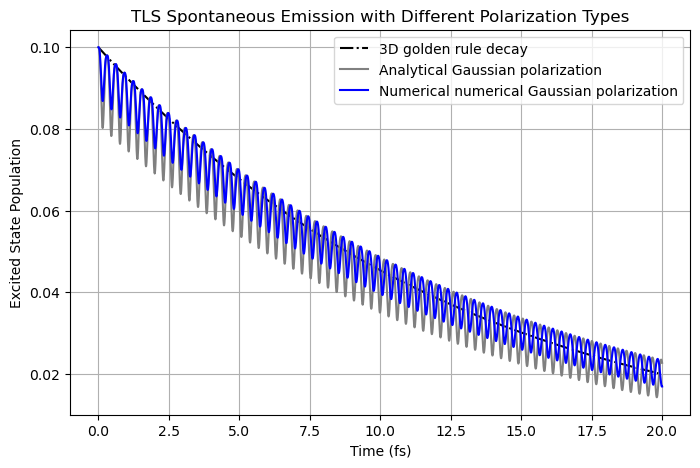

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(time_fs_a, population_fgr, "k-.", label="3D golden rule decay")
plt.plot(time_fs_a, population_a, "0.5", label="Analytical Gaussian polarization")
plt.plot(time_fs_n, population_n, "b", label="Numerical numerical Gaussian polarization")
plt.xlabel("Time (fs)")
plt.ylabel("Excited State Population")
plt.title("TLS Spontaneous Emission with Different Polarization Types")
plt.legend()
plt.grid()
plt.show()


Then, if we exclude the longitudinal component of the **self-emitted** E-field ($\mathbf{E}_{\parallel}^m$, red line), the oscillations can be reduced further.

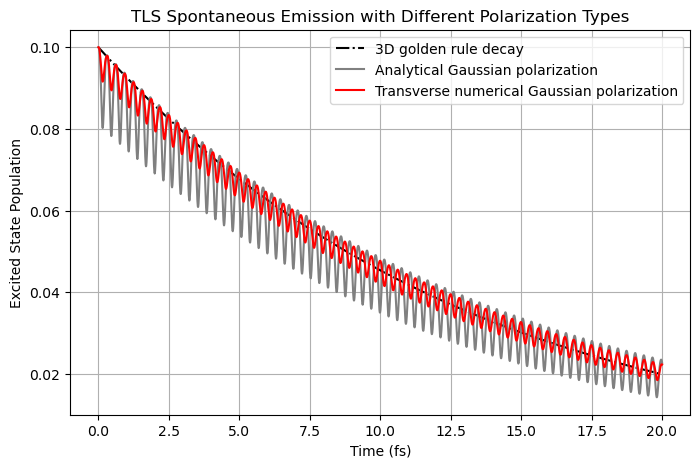

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(time_fs_a, population_fgr, "k-.", label="3D golden rule decay")
plt.plot(time_fs_a, population_a, "0.5", label="Analytical Gaussian polarization")
plt.plot(time_fs_t, population_t, "r", label="Transverse numerical Gaussian polarization")
plt.xlabel("Time (fs)")
plt.ylabel("Excited State Population")
plt.title("TLS Spontaneous Emission with Different Polarization Types")
plt.legend()
plt.grid()
plt.show()

If we use the point dipole in the simulations, although we have taken a strategy to reduce the fluctuations (during the light-matter evaluations, the E-field averaged over a $\Delta x^3$ box is used), very strong oscillations can be observed during spontaneous emission. Without this strategy that we enforce all the time, the simulaiton result would be completely wrong.

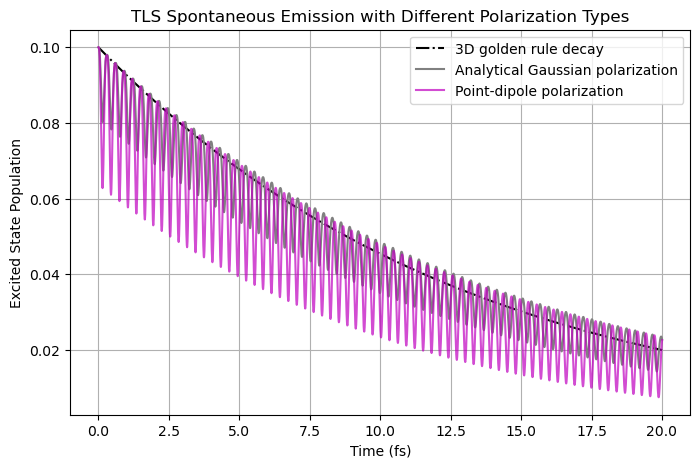

In [5]:
plt.figure(figsize=(8, 5))
plt.plot(time_fs_a, population_fgr, "k-.", label="3D golden rule decay")
plt.plot(time_fs_a, population_a, "0.5", label="Analytical Gaussian polarization")
plt.plot(time_fs_p, population_p, "m", label="Point-dipole polarization", alpha=0.7)
plt.xlabel("Time (fs)")
plt.ylabel("Excited State Population")
plt.title("TLS Spontaneous Emission with Different Polarization Types")
plt.legend()
plt.grid()
plt.show()

Below provides the results corresponding to the raw point-dipole approximation (with no E-field averaging over a $\Delta x^3$ box). Clearly, the spontaneous emission decay becomes completely wrong.

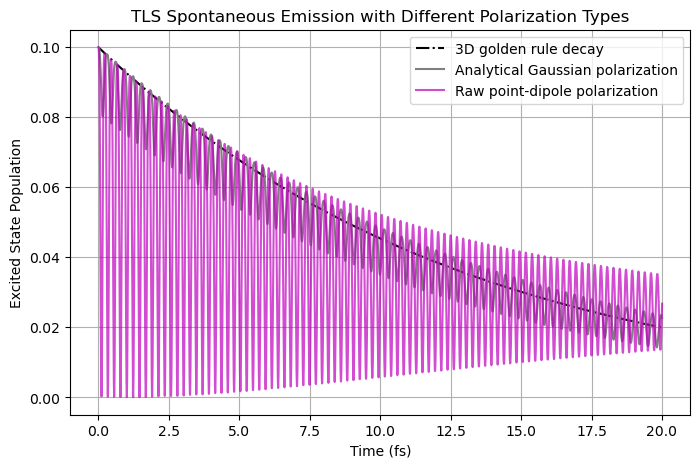

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(time_fs_a, population_fgr, "k-.", label="3D golden rule decay")
plt.plot(time_fs_a, population_a, "0.5", label="Analytical Gaussian polarization")
plt.plot(time_fs_pr, population_pr, "m", label="Raw point-dipole polarization", alpha=0.7)
plt.xlabel("Time (fs)")
plt.ylabel("Excited State Population")
plt.title("TLS Spontaneous Emission with Different Polarization Types")
plt.legend()
plt.grid()
plt.show()

Finally, for the anisotropic Gaussian function, because the definition here is slightly different from the default analytical Gaussian function,
\begin{equation}
\mathbf{\kappa}_{\rm {aso}}(\mathbf{r}) = \frac{1}{(2\pi)^{3/2} \sigma_x^{1/2}  \sigma_y^{1/2}  \sigma_z^{1/2}} e^{-x^2/\sigma_x^2}e^{-y^2/\sigma_y^2}e^{-z^2/\sigma_z^2} \hat{e}_z ,
\end{equation}
a very small difference is still observed when $\sigma_x = \sigma_y = \sigma_z$.

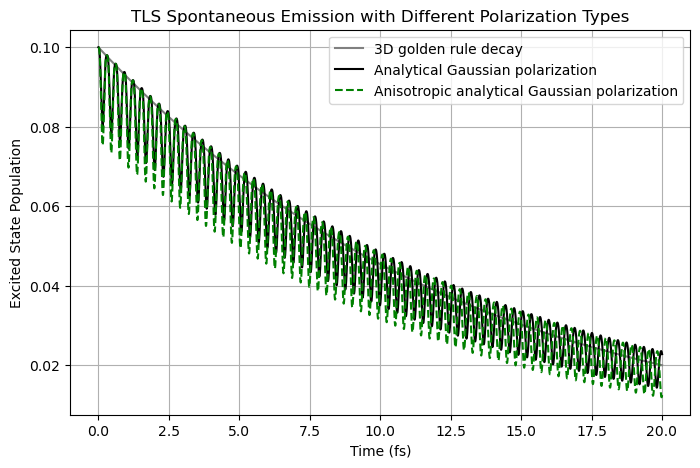

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(time_fs_a, population_fgr, "0.5", label="3D golden rule decay")
plt.plot(time_fs_a, population_a, "k", label="Analytical Gaussian polarization")
plt.plot(time_fs_aso, population_aso, "g--", label="Anisotropic analytical Gaussian polarization")
plt.xlabel("Time (fs)")
plt.ylabel("Excited State Population")
plt.title("TLS Spontaneous Emission with Different Polarization Types")
plt.legend()
plt.grid()
plt.show()